# Figure 3

- See Fig3a_UMAP.ipynb for fig 3a (UMAP plots)
    - UMAP package necessitates a virtual environment


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

# 3b-d

In [13]:
ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')
ABE_LFC['Editor']='ABE'
CBE_LFC['Editor']='CBE'

LFC_comb = pd.concat((ABE_LFC, CBE_LFC))

min_input_counts = 2

#key = ['gene_name_m_corrected', 'LFC_median_d15', 'LFC_median_spleen', 'LFC_median_bonemarrow', 'LFC_median_meninges']
#val = ['gene_name_m', 'LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']

#col_dict = dict(zip(key, val))

master_targ = LFC_comb[(LFC_comb['classification']=='targeting guide') & (LFC_comb['Input_median']>=min_input_counts)].reset_index(drop=True) #.rename(columns=col_dict)

#and add TSG/Oncogene info

cosmic = pd.read_csv('source_data/Census_allSun Nov 17 02_26_47 2024.csv').fillna('Undefined')


t_dict = {'TSG':'TSG', 'TSG, fusion':'TSG', 'Undefined':'Undefined', 'fusion':'Undefined', 'oncogene':'Oncogene',
       'oncogene, TSG':'Oncogene/TSG', 'oncogene, TSG, fusion':'Oncogene/TSG', 'oncogene, fusion': 'Oncogene'}

gene_type = []
for i, val in master_targ.iterrows():
    v = val['gene_name_h']
    subset = cosmic[cosmic['Gene Symbol']==v]
    if len(subset)==0:
        gene_type.append('Undefined')
    else:
        v2 = subset['Role in Cancer'].values[0]

        gene_type.append(t_dict[v2])

master_targ['Role in Cancer']=gene_type

In [14]:
master_targ

#exclude bonemarrow due to close association with spleen
#samples = ['LFC_median_d15', 'LFC_median_spleen', 'LFC_median_bonemarrow', 'LFC_median_meninges']

samples = ['LFC_median_d15', 'LFC_median_spleen', 'LFC_median_meninges']


#calculate the difference in LFC between a given tissue and all other contexts

for idx, val in enumerate(samples):

    #nums = [0,1,2,3]
    nums = [0,1,2]
    nums.remove(idx)

    considering = master_targ[val]
    avgs = np.average(master_targ[[samples[i] for i in nums]], axis=1)

    delta = considering-avgs
    master_targ[f"d_{val.split('_')[2]}"] = delta



In [15]:
def barplotter(subset, save_name, figtitle, figwidth=12.5, figheight=4.5, save=False):
    """ 
    Function for making barplots/stripplots showing editing percentage in all tissues

    """

    t1 = subset.fillna('Non-coding')

    CBE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
    'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
    'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
    'd5':['d5_rep1','d5_rep2','d5_rep3'],
    'd15':['d15_rep1','d15_rep2','d15_rep3'],
    'plasmid_lib':['plasmidlib']}

    ABE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
    'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
    'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
    'd5':['d5_rep1','d5_rep2','d5_rep3'],
    'd15':['d15_rep1','d15_rep2','d15_rep3'],
    'plasmid_lib':['plasmidlib']}

    samples2 = ['d15', 'spleen', 'bonemarrow', 'meninges']

    name = []
    tissue = []
    LFC = []
    gRNA_id = []

    xlabs = []
    for i, val in t1.iterrows():
        
        a = val['gene_name_h']
        b = val['HGVSp_h']
        c = val['gene_name_m_corrected']
        d = val['HGVSp_m']

        if b[:2]=='p.':
            b = b[2:]
        if 'delins' in b:
            b = b.replace('delins', '')
        if d=='Not calculated (legacy)':
            d = b
        

        editor = val['Editor']

        n = f'{a} {b}\n{c} {d}'

        xlabs.append(n)
        for s in samples2:

            if editor=='ABE':
                samps = ABE_samp_dict[s]
            elif editor=='CBE':
                samps = CBE_samp_dict[s]

            for j in samps:
                LFC.append(val[j])
                name.append(n)
                tissue.append(s)
                gRNA_id.append(val['gRNA_id'])
        


    plotting_df = pd.DataFrame(dict(zip(['gRNA_id', 'Mutation', 'Tissue', 'LFC'], [gRNA_id, name, tissue, LFC])))
        
    fig, ax = plt.subplots(2,1, figsize=(figwidth,figheight), height_ratios=[1,7], sharex=False)

    palette = ['#F9CBA8', '#ED6A50', '#7284A1', 'lightgrey', 'darkslategray']

    palette = ['lightgrey','cadetblue','slateblue','lightcoral', '#ED6A50',]

    sns.heatmap([np.asarray(t1['target_base_edit_perc'])], ax=ax[0], cbar=False, cmap='Reds', linewidth=1, annot=True, annot_kws={"fontsize":12}, vmin=0, vmax=100,fmt='.3g')
    g = sns.boxplot(data=plotting_df, x='gRNA_id', y='LFC', hue='Tissue', ax=ax[1], legend=False, palette=palette, showfliers=False)
    sns.stripplot(data=plotting_df, x='gRNA_id', y='LFC', hue='Tissue', ax=ax[1], dodge=True, edgecolor='black', linewidth=1, legend=False, palette=palette)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[1].set_xticklabels(xlabs)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('LFC', fontsize=12)

    #ax[1].plot([0,8], [0,0], color='black', linestyle='dashed')
    ax[1].spines[['top', 'right']].set_visible(False)
    ax[1].tick_params(axis='x', which='major', labelsize=10)
    ax[1].tick_params(axis='y', which='major', labelsize=12)

    color_dict = {'ABE':'tab:purple', 'CBE':'tab:blue'}
    t2 = list(t1['Editor'])
    for idx, tick_label in enumerate(g.axes.get_xticklabels()):

        tick_label.set_color(color_dict[t2[idx]])


    ax[1].axhline(0, linestyle='dashed', color='black', linewidth=.5)

    for k in range(len(t1)-1):
        ax[1].axvline(k+.5, linestyle='dashed', color='black', linewidth=.5)

    ax[0].set_title(f'{figtitle}', fontsize=14)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    if save==True:
        fig.savefig(f'figures/{save_name}.pdf')

In [16]:
FDR_cutoff = .1

# in vitro specific

#spleen, meninges, bone LFC <0
#in vitro LFC > 01
# FDR <.1 in vitro
t = master_targ.sort_values(by='d_d15', ascending=False)
invitro_specific = t[(t['LFC_median_spleen']<0) & (t['LFC_median_meninges']<0) & (t['LFC_median_bonemarrow']<0) & (t['LFC_median_d15']>1) & (t['target_base_edit_perc']>=1) & (t['FDR_d15']<FDR_cutoff)]
print(f'in vitro specific: {len(invitro_specific)}')

# in vivo specific
#spleen, meninges, bone LFC >0
#in vitro LFC < 0
# FDR <.1 in at least 1 in vivo context
t2 = master_targ.sort_values(by='d_d15', ascending=True)
invivo_specific = t[(t['LFC_median_spleen']>0) & (t['LFC_median_meninges']>0) & (t['LFC_median_bonemarrow']>0) & (t['LFC_median_d15']<0) & (t['target_base_edit_perc']>=1)]
#FDR thresholding
invivo_specific2 = invivo_specific[(invivo_specific['FDR_spleen']<FDR_cutoff) | (invivo_specific['FDR_bonemarrow']<FDR_cutoff) | (invivo_specific['FDR_meninges']<FDR_cutoff)]
invivo_specific2 = invivo_specific2.sort_values(by='d_d15', ascending=True)
print(f'in vivo specific: {len(invivo_specific2)}')


# spleen/bone specific
# spleen LFC >1 (not thresholding on bonemarrow; goes in step with spleen)
# meninges, in vitro LFC <0
# FDR <.1 in spleen
t3 = master_targ.sort_values(by='d_spleen', ascending=False)
bonespleen_specific = t3[(t3['LFC_median_spleen']>1) & (t3['LFC_median_meninges']<0) & (t3['LFC_median_d15']<0) & (t3['target_base_edit_perc']>=1) & (t3['FDR_spleen']<FDR_cutoff)]
print(f'bone/spleen specific: {len(bonespleen_specific)}')

#meninges specific (NO HITS)
# meninges LFC >0
# other LFC <0
# FDR <.1 in meninges 
t4 = master_targ.sort_values(by='d_meninges', ascending=False)
meninges_specific = t4[(t4['LFC_median_spleen']<0) & (t4['LFC_median_meninges']>0) & (t4['LFC_median_d15']<0) & (t4['target_base_edit_perc']>=1) & (t4['FDR_meninges']<FDR_cutoff)]
print(f'meninges specific: {len(meninges_specific)}')


in vitro specific: 7
in vivo specific: 22
bone/spleen specific: 81
meninges specific: 0


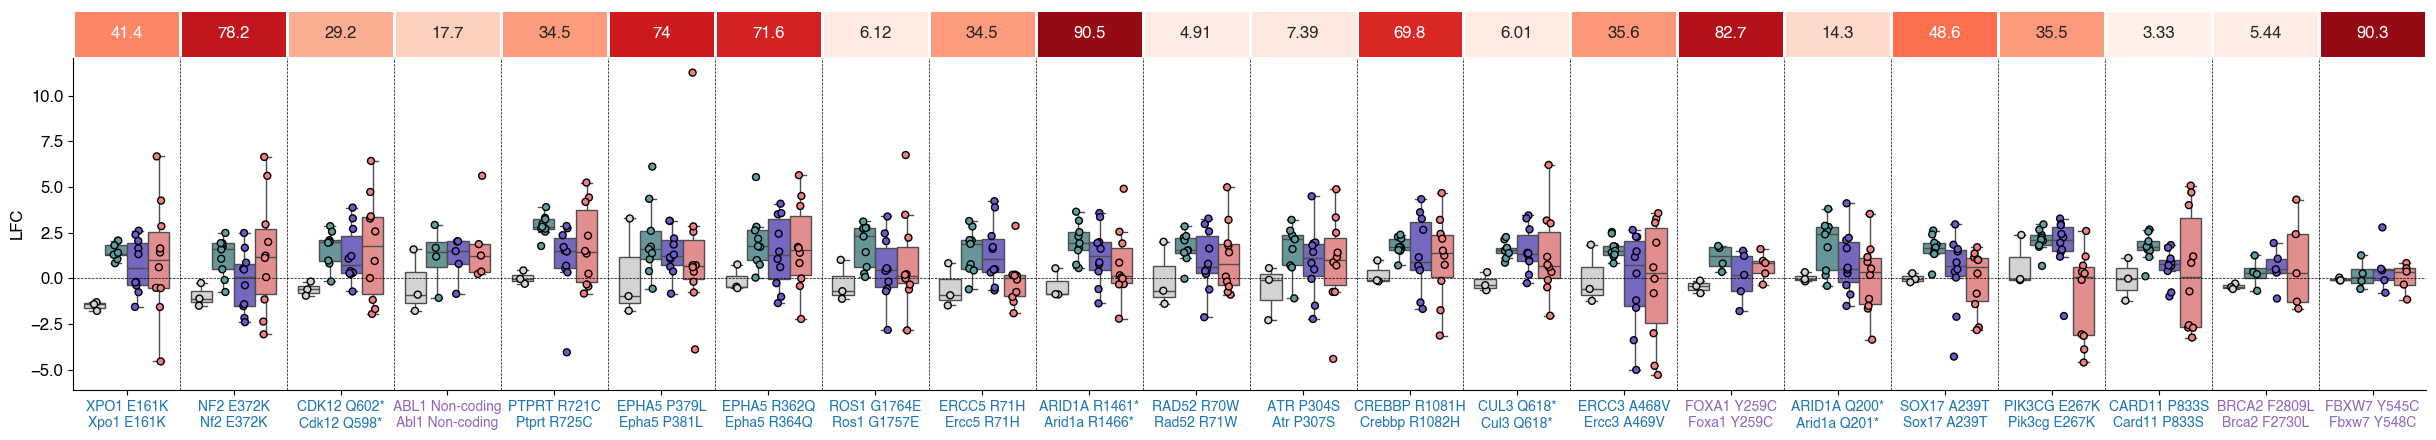

In [17]:
barplotter(invivo_specific2, 'invivo_specific_hits', '',figwidth=24.5, figheight=4.5, save=False)

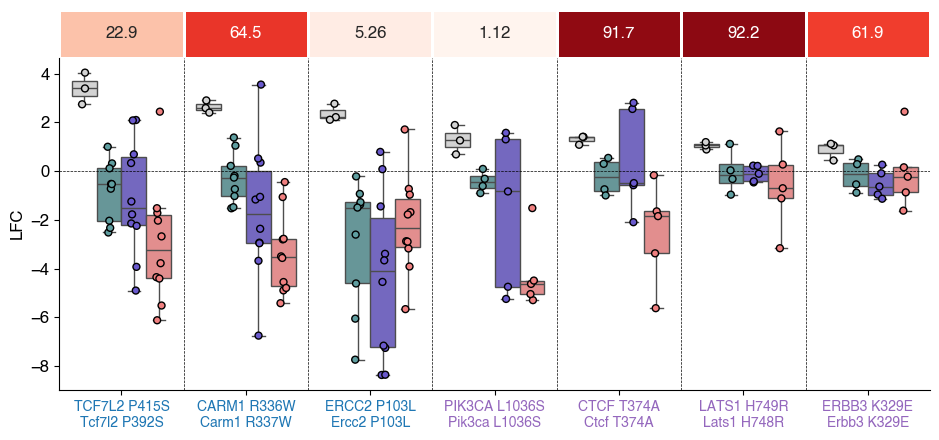

In [18]:
barplotter(invitro_specific, 'invitro_specific_hits', '',figwidth=9.5, figheight=4.5, save=False)

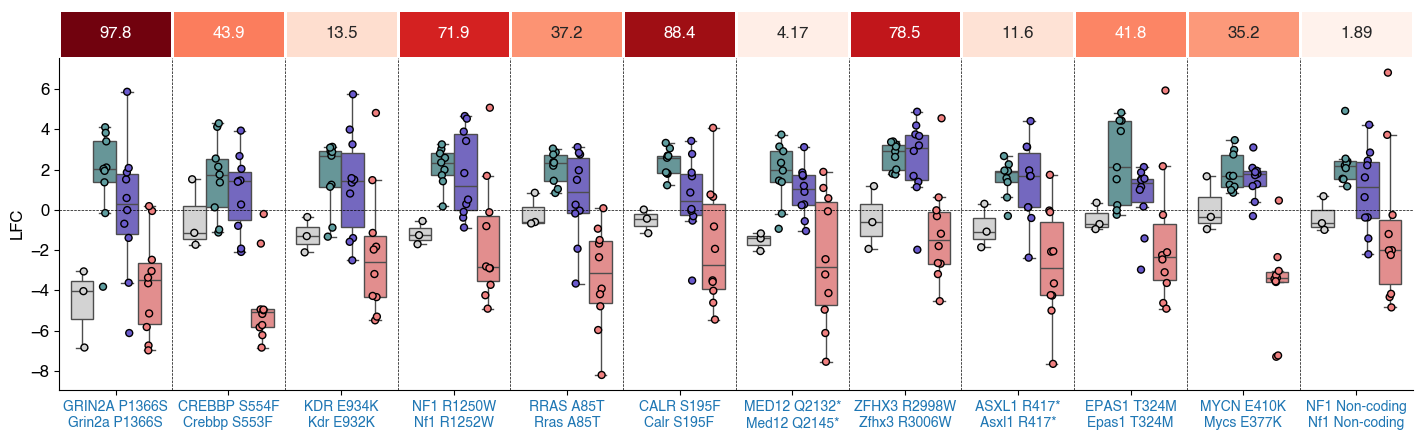

In [19]:
#plotting the top 12 hits (by delta from spleen vs. other tissues)
barplotter(bonespleen_specific[:12], 'bonespleen_specific_hits', '',figwidth=14.5, figheight=4.5, save=False)

In [20]:
#list of highlighted guides for use in UMAP plot
g_list = [list(invitro_specific['gRNA_id']), list(invivo_specific2['gRNA_id']), list(bonespleen_specific[:12]['gRNA_id'])]
g_list

[['gRNA_12301',
  'gRNA_1840',
  'gRNA_3670',
  'gRNA_8831',
  'gRNA_2401',
  'gRNA_6745',
  'gRNA_3570'],
 ['gRNA_13064',
  'gRNA_7807',
  'gRNA_2051',
  'gRNA_2',
  'gRNA_10211',
  'gRNA_3233',
  'gRNA_3238',
  'gRNA_10757',
  'gRNA_3765',
  'gRNA_631',
  'gRNA_10312',
  'gRNA_1086',
  'gRNA_2295',
  'gRNA_2524',
  'gRNA_3742',
  'gRNA_4578',
  'gRNA_677',
  'gRNA_14337',
  'gRNA_9020',
  'gRNA_1765',
  'gRNA_1592',
  'gRNA_4105'],
 ['gRNA_5054',
  'gRNA_2218',
  'gRNA_5978',
  'gRNA_7652',
  'gRNA_10884',
  'gRNA_1719',
  'gRNA_7038',
  'gRNA_13228',
  'gRNA_949',
  'gRNA_3136',
  'gRNA_7502',
  'gRNA_7709']]

# 3e

In [21]:
ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')

LFC_comb = pd.concat((ABE_LFC, CBE_LFC))

min_input_counts = 2

key = ['gene_name_m_corrected', 'LFC_median_d15', 'LFC_median_spleen', 'LFC_median_bonemarrow', 'LFC_median_meninges']
val = ['gene_name_m', 'LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']

col_dict = dict(zip(key, val))

master_targ = LFC_comb[(LFC_comb['classification']=='targeting guide') & (LFC_comb['Input_median']>=min_input_counts)].reset_index(drop=True).rename(columns=col_dict)
#master_targ = master[master['classification']=='targeting guide']

In [22]:
u, c = np.unique(master_targ['gene_name_m'], return_counts=True)
dd = pd.DataFrame(dict(zip(['gene', 'gRNA count'], [u,c]))).sort_values(by='gRNA count', ascending=False)

dd = dd[dd['gRNA count']>=50]


samples = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']

spleen_bone = []
spleen_meninges = []
spleen_d15 = []
bone_meninges = []
bone_d15 = []
d15_meninges = []


for gene in dd['gene']:
    ptprt = master_targ[(master_targ['gene_name_m']==gene)]

    for i, val in enumerate(samples):

        x = ptprt[val]

        for i2, val2 in enumerate(samples):

            y = ptprt[val2]

            s1 = scipy.stats.pearsonr(x,y).statistic

            if val=='LFC_Spleen':
                if val2 =='LFC_Bone':
                    spleen_bone.append(s1)

                elif val2=='LFC_Meninges':
                    spleen_meninges.append(s1)

                elif val2=='LFC_In Vitro D15':
                    spleen_d15.append(s1)

            elif val == 'LFC_Bone':
                if val2=='LFC_Meninges':
                    bone_meninges.append(s1)
                elif val2=='LFC_In Vitro D15':
                    bone_d15.append(s1)
            elif val=='LFC_In Vitro D15':
                if val2=='LFC_Meninges':
                    d15_meninges.append(s1)
            
            else:
                continue

a = ['In Vitro vs. Spleen', 'In Vitro vs. Bone', 'In Vitro vs. Meninges', 'Spleen vs. Bone', 'Spleen vs. Meninges', 'Bone vs. Meninges']
b = [spleen_d15, bone_d15, d15_meninges, spleen_bone, spleen_meninges, bone_meninges]

df_holder = []
for i, val in enumerate(b):
    hh = a[i]
    d1 = pd.DataFrame(dict(zip(['Correlation'], [val])))
    d1['Comparison'] = hh
    df_holder.append(d1)

comps = pd.concat(df_holder).reset_index(drop=True)

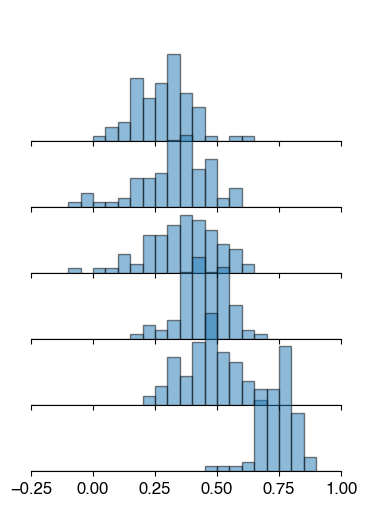

In [23]:
fig, ax= plt.subplots(6,1, figsize=(4,6), sharey=True, sharex=True)

a = ['In Vitro vs. Meninges', 'In Vitro vs. Bone', 'In Vitro vs. Spleen', 'Bone vs. Meninges','Spleen vs. Meninges', 'Spleen vs. Bone',]

bins = np.linspace(-1,1,41)
for idx, val in enumerate(a):

    subset = comps[comps['Comparison']==val]
    ax[idx].hist(subset['Correlation'], bins=bins, linewidth=1, edgecolor='black', alpha=.5)
    ax[idx].spines[['top', 'right', 'left']].set_visible(False)
    ax[idx].tick_params(axis='x', which='major', labelsize=12)
    ax[idx].set_yticks([])
    ax[idx].patch.set_facecolor('None')

ax[0].set_xlim(-.25,1)

fig.subplots_adjust(hspace=-.5)

#fig.savefig('figures/corr_hist_v2.pdf', transparent=True)

# 3f

In [24]:
ABE_LFC = pd.read_csv('ABE_LFC_FDR_df.csv')
CBE_LFC = pd.read_csv('CBE_LFC_FDR_df.csv')
ABE_LFC['Editor']='ABE'
CBE_LFC['Editor']='CBE'

LFC_comb = pd.concat((ABE_LFC, CBE_LFC))

min_input_counts = 2

key = ['gene_name_m_corrected', 'LFC_median_d15', 'LFC_median_spleen', 'LFC_median_bonemarrow', 'LFC_median_meninges']
val = ['gene_name_m', 'LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']

col_dict = dict(zip(key, val))

master_targ = LFC_comb[(LFC_comb['classification']=='targeting guide') & (LFC_comb['Input_median']>=min_input_counts)].reset_index(drop=True).rename(columns=col_dict)

In [25]:
u,c = np.unique(master_targ['gene_name_m'], return_counts=True)
top_genes = pd.DataFrame(dict(zip(['u', 'c'], [u,c]))).sort_values(by='c', ascending=False)[:20]
top_genes

,u,c
226,Kmt2d,274
17,Arid1a,230
352,Ptprt,227
414,Smarca4,194
466,Trp53,173
487,Zfhx3,162
176,Grin2a,161
351,Ptprs,147
287,Notch1,147
350,Ptprd,146


167
167
167
167
144
144
144
144
153
153
153
153
136
136
136
136
92
92
92
92


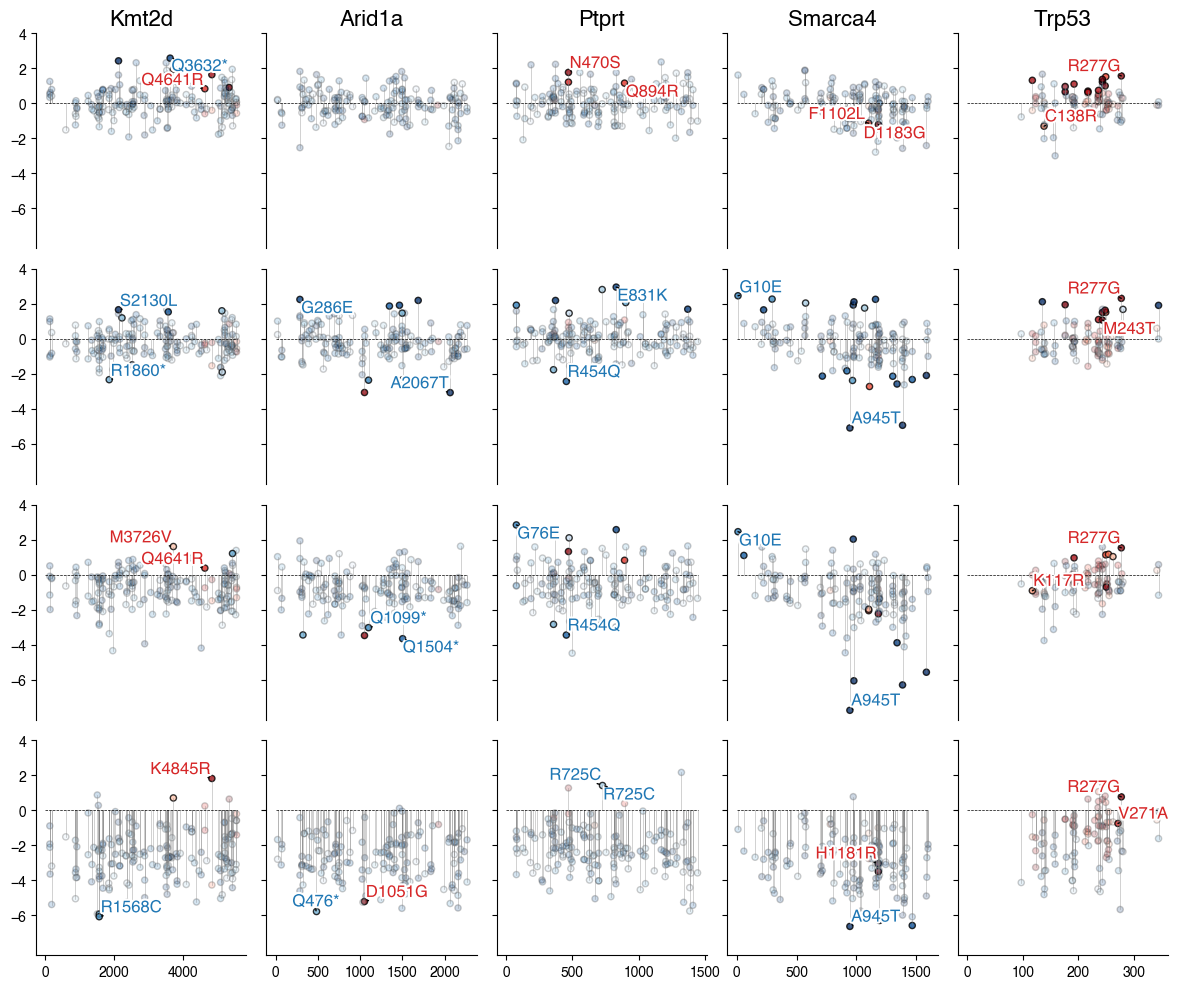

In [26]:

#for idx, gene in enumerate(top_genes[:5]):
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

#gene = 'Smarca4'
FDR_cutoff = .1

genes = ['Kmt2d', 'Arid1a', 'Ptprt', 'Smarca4', 'Trp53']

fig, ax = plt.subplots(4,5,figsize=(12,10), sharey=True) #sharey='col',)

cc1 = master_targ

for idx, gene in enumerate(genes):

    ptprt = cc1[(cc1['gene_name_m']==gene)  & (~cc1['HGVSp_m'].isin(['Not calculated (legacy)', 'Non-coding'])) & (cc1['target_base_edit_perc']>=20)]

    ptprt['codon'] = [int(i[1:-1]) for i in ptprt['HGVSp_m']]


    #samples = ['Z_In Vitro D15', 'Z_Spleen', 'Z_Bone', 'Z_Meninges']
    samples = ['LFC_In Vitro D15', 'LFC_Spleen', 'LFC_Bone', 'LFC_Meninges']
    FDR_samp = ['FDR_d15', 'FDR_spleen', 'FDR_bonemarrow', 'FDR_meninges']
    samp_dict = dict(zip(samples, ['In Vitro', 'Spleen', 'Bone', 'Meninges']))
    for kk, val2 in enumerate(samples):

        for i, val in ptprt.iterrows():
            x = val['codon']
            y = val[val2]

            ax[kk][idx].plot([x,x],[0,y], color='tab:gray', linewidth=0.5, alpha=.5)


        ptprt1 = ptprt[ptprt['Editor']=='ABE']
        ptprt2 = ptprt[ptprt['Editor']=='CBE']

        print(len(ptprt))
        #marker_sizes1 = 5*(-np.log10(np.asarray(sorted(ptprt1[f'FDR_{val2[4:]}']))+1e-10))**2 + 20
        #marker_sizes2 = 5*(-np.log10(np.asarray(sorted(ptprt2[f'FDR_{val2[4:]}']))+1e-10))**2 + 20


       # ptprt1_1 = ptprt1[(ptprt1[val2]<=1.5) | (ptprt1[val2]>=-1.5)]
        #ptprt1_2 = ptprt1[(ptprt1[val2]>=1.5) | (ptprt1[val2]<=-1.5)]

        ptprt1_1 = ptprt1[ptprt1[FDR_samp[kk]]>=FDR_cutoff]
        ptprt1_2 = ptprt1[ptprt1[FDR_samp[kk]]<FDR_cutoff]

        ptprt2_1 = ptprt2[ptprt2[FDR_samp[kk]]>=FDR_cutoff]
        ptprt2_2 = ptprt2[ptprt2[FDR_samp[kk]]<FDR_cutoff]

        #ptprt2_1 = ptprt2[(ptprt2[val2]<=1.5) | (ptprt2[val2]>=-1.5)]
        #ptprt2_2 = ptprt2[(ptprt2[val2]>=1.5) | (ptprt2[val2]<=-1.5)]

        #ptprt1_1 = ptprt1[(ptprt1[val2]<=1.5)] 
        #ptprt1_2 = ptprt1[(ptprt1[val2]>=1.5)] 
        #ptprt2_1 = ptprt2[(ptprt2[val2]<=1.5)] 
        #ptprt2_2 = ptprt2[(ptprt2[val2]>=1.5)]

        ax[kk][idx].scatter(ptprt1_1['codon'], ptprt1_1[val2], c=ptprt1_1['target_base_edit_perc'], cmap='Reds', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.2)
        ax[kk][idx].scatter(ptprt1_2['codon'], ptprt1_2[val2], c=ptprt1_2['target_base_edit_perc'], cmap='Reds', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.8)



        ax[kk][idx].scatter(ptprt2_1['codon'], ptprt2_1[val2], c=ptprt2_1['target_base_edit_perc'], cmap='Blues', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.2)
        ax[kk][idx].scatter(ptprt2_2['codon'], ptprt2_2[val2], c=ptprt2_2['target_base_edit_perc'], cmap='Blues', s=20, vmin=0, vmax=100, edgecolor='black', linewidth=1, alpha=.8)

        #and annotate top 2 and bototm 2 variants
           #and annotate top and bottom 5 variant
        tops = pd.concat((ptprt1_2, ptprt2_2)).sort_values(by=val2, ascending=False)[:1]
        bottoms = pd.concat((ptprt1_2, ptprt2_2)).sort_values(by=val2, ascending=True)[:1]
        tb = pd.concat((tops, bottoms))

        t = []
        x = []
        y = []
        c = []

        c_dict2 = {'ABE':'tab:red', 'CBE':'tab:blue'}
        for i, val3 in tb.iterrows():
            y.append(val3[val2])
            x.append(val3['codon'])
            c.append(c_dict2[val3['Editor']])
            a = val3['HGVSp_m']
    
            t.append(a)


        texts = [ax[kk][idx].text(x[i], y[i], t[i], fontsize=12, color=c[i], path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                    foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)

        adjust_text(texts, only_move={'points':'xy', 'texts':'xy'}, ax=ax[kk][idx], arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))



        #ax[kk].legend(*sc.legend_elements("sizes", num=6))
        #ax[kk].set_title(samp_dict[val2], fontsize=14)

        if kk==3:
            ax[kk][idx].spines[['top', 'right']].set_visible(False)
        else:
            ax[kk][idx].spines[['top', 'right', 'bottom']].set_visible(False)
            ax[kk][idx].set_xticks([])


        ax[kk][idx].tick_params(axis='both', which='major', labelsize=10,)
        ax[kk][idx].plot([0, max(ptprt['codon'])], [0,0], linestyle='dashed', color='black',linewidth=.5)
        #ax[kk][idx].plot([0, max(ptprt['codon'])], [1.5,1.5], linestyle='dashed', color='black',linewidth=.5)
        #ax[kk][idx].plot([0, max(ptprt['codon'])], [-1.5,-1.5], linestyle='dashed', color='black',linewidth=.5)

        ax[kk][idx].set_yticks([-6,-4,-2,0,2,4])

        ax[0][idx].set_title(f'{gene}', fontsize=16)
        #ax[0][idx].set_ylim(-5,5)
        ax[kk][idx].patch.set_facecolor('None')

fig.tight_layout()
#fig.savefig('figures/lolliplops_transparent_v2_FDR.png', dpi=300, transparent=True)